In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import callbacks
from uproot_io import Events, View

In [29]:
# the data
events1 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_1.root")
events2 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_2.root")
events3 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_3.root")
events4 = Events("/Users/mohammed/code/neutrinos-dune-files/CheatedRecoFile_4.root")

In [30]:
# getting the event indices and finding the number of events in each file
numbers1 = np.array(list(set(events1.event_number)))
numbers2 = np.array(list(set(events2.event_number)))
numbers3 = np.array(list(set(events3.event_number)))
numbers4 = np.array(list(set(events4.event_number)))
len(numbers1), len(numbers2), len(numbers3), len(numbers4)

(9310, 9265, 9310, 9257)

In [31]:
# creating view classes for each event
view_w1 = View(events1, "w")
view_w2 = View(events2, "w")
view_w3 = View(events3, "w")
view_w4 = View(events4, "w")

In [32]:
def plot_w_event(view_w, number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

In [33]:
def process_numbers(numbers, events):
    labels = []
    for n in numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            labels.append([0, 1, 0])
        elif 13 in mcp or -13 in mcp:
            labels.append([1, 0, 0])
        else:
            labels.append([0, 0, 1])
    return labels

def oneHotLabelling(numbers_list, events_list):
    labels = []
    for numbers, events in zip(numbers_list, events_list):
        labels.extend(process_numbers(numbers, events))
    return np.array(labels).astype(float)

In [34]:
# Usage
numbers_list = [numbers1, numbers2, numbers3, numbers4]
events_list = [events1, events2, events3, events4]
labels = oneHotLabelling(numbers_list, events_list)

In [37]:
labels[2]

array([1., 0., 0.])

In [45]:
np.savetxt('array.txt', labels, delimiter=',', fmt='%d')

In [38]:
def imagenew(numbers_list, views_list):
    images = []
    
    for numbers, view_w in zip(numbers_list, views_list):
        for n in numbers:
            x, z, adc, vx, vz = view_w.x[n], view_w.z[n], view_w.adc[n], view_w.true_vtx_x[n], view_w.true_vtx_z[n]
            
            x_mean, z_mean = np.floor(np.mean(x)), np.floor(np.mean(z))
            minusx, plusx = x_mean - 100, x_mean + 100
            minusz, plusz = z_mean - 100, z_mean + 100

#             # Adjusting the range based on vertex positions
#             minusx, plusx = min(minusx, np.floor(vx) - 25), max(plusx, np.floor(vx) + 25)
#             minusz, plusz = min(minusz, np.floor(vz) - 25), max(plusz, np.floor(vz) + 25)
            
            if vx < minusx:
                minusx = np.floor(vx)-20
                plusx = np.floor(vx)+180
            if vx > plusx:
                minusx = np.floor(vx)-180
                plusx = np.floor(vx)+20
            if vz < minusz:
                minusz = np.floor(vz)-20
                plusz = np.floor(vz)+180
            if vz > plusz:
                minusz = np.floor(vz)-180
                plusz = np.floor(vz)+20

            matrix, _, _ = np.histogram2d(x, z, bins=128, range=[[minusx, plusx], [minusz, plusz]], weights=adc)
            matrix = (matrix > 0).astype(np.uint8).reshape(128, 128, 1)
            images.append(matrix)

    return np.stack(images)

In [39]:
# Usage example
numbers_list = [numbers1, numbers2, numbers3, numbers4]
views_list = [view_w1, view_w2, view_w3, view_w4]
all_images = imagenew(numbers_list, views_list)

In [76]:
all_images.shape

(37142, 128, 128, 1)

In [77]:
all_images_squeezed = np.squeeze(all_images)

# Check for all-zero matrices in a vectorized manner
is_all_zero = np.all(all_images_squeezed == 0, axis=(1, 2))

# Indices of all-zero matrices
all_zeros_indices = np.where(is_all_zero)[0]

len(all_zeros_indices)

1552

In [115]:
# Use this mask to select only the images that are not completely zeros
keep_images_mask = ~is_all_zero

# Apply this mask to filter out the all-zero images
filtered_images = all_images[keep_images_mask]

In [116]:
filtered_images.shape

(35590, 128, 128, 1)

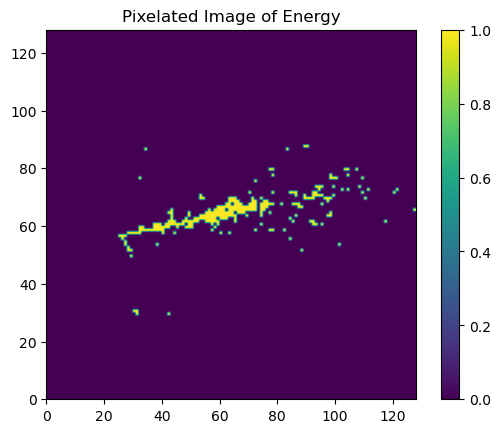

In [132]:
# Display the pixelated image
image_to_display = filtered_images[32795].reshape(128,128)

plt.imshow(image_to_display, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
plt.colorbar()
plt.title('Pixelated Image of Energy')
plt.show()

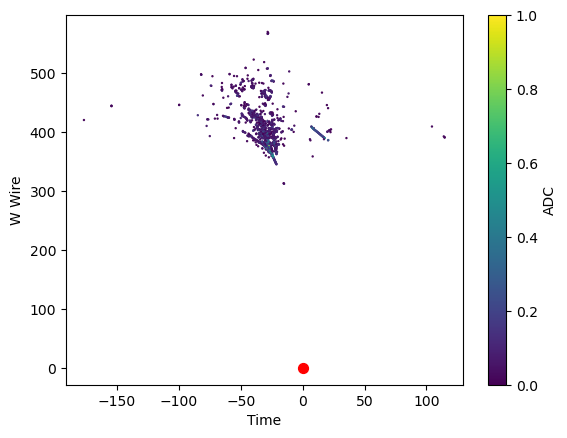

In [133]:
plot_w_event(view_w1, 31)

In [134]:
# index 0-9309 (file1), 9310-18574 (file2), 18575-27884 (file3), 27885-37141 (file4)

In [135]:
# Generate random indices
random_numbers = np.random.permutation(len(labels))

# Calculate the indices for each subset
sixty_percent = int(0.6 * len(random_numbers))
ten_percent = int(0.1 * len(random_numbers))

# Split the indices into training, validation, and testing
training_indices = random_numbers[:sixty_percent]
validation_indices = random_numbers[sixty_percent:sixty_percent + ten_percent]
testing_indices = random_numbers[sixty_percent + ten_percent:]

In [136]:
# Splitting the data
x_train = all_images[training_indices]
y_train = labels[training_indices]

x_val = all_images[validation_indices]
y_val = labels[validation_indices]

x_test = all_images[testing_indices]
y_test = labels[testing_indices]

In [47]:
np.savetxt('array.txt', training_indices, delimiter=',', fmt='%d')

In [137]:
np.save('x_train', x_train)
np.save('y_train', y_train)

np.save('x_val', x_val)
np.save('y_val', y_val)

np.save('x_test', x_test)
np.save('y_test', y_test)

In [19]:
len(x_train), len(x_val), len(x_test)

(22285, 3714, 11143)

In [44]:
from tensorflow.keras.models import load_model
model = load_model('/Users/mohammed/code/neutrinos-dune-files/modelv2')

2024-02-01 18:25:09.327032: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-01 18:25:09.327181: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-01 18:25:09.327375: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-01 18:25:09.328057: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-01 18:25:09.328708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [56]:
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 128)       738

In [51]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 1
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [52]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [ ]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_val, y_val), verbose = 1)

In [54]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

 1/88 [..............................] - ETA: 26s

2024-02-01 18:26:15.484357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 22s 252ms/step
Number of images that were incorrectly classified = 4431


In [55]:
(11143-4431)/11143

0.6023512519070269

In [21]:
num_classes = 3

In [22]:
# model 1

input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.25)(x) # Replace None with a droput layer with a fraction of 0.25
# x = keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = keras.layers.MaxPooling2D((2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 3)                 1548387   
                                                             

In [24]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 1
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [25]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [27]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
history = cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)


175/175 [==============================] - 133s 757ms/step - loss: 0.5238 - accuracy: 0.7941 - val_loss: 0.7826 - val_accuracy: 0.6770


In [28]:
with open('training_history.json', 'w') as file:
    import json
    history_dict = history.history
    json.dump(history_dict, file)